# Финальный проект. Кейс "АВ-тест"

## Описание

Задача — провести оценку результатов A/B-теста. В нашем распоряжении датасет с действиями пользователей, датасет с маркетинговыми кампаниями, датасет с группами АВ-тестов, датасет с датами регистрации пользователей.

- Рассматриваемый АВ-тест: recommender_system_test
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки теста: 2021-01-04;
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
 * конверсии в просмотр карточек товаров — событие product_page
 * просмотры корзины — product_cart
 * покупки — purchase

Поставленные задачи:
* Оценить корректность проведения теста.
* Проанализировать результаты теста.

План работы:
* Подготовить данные, оценить их целостность:
 * Требуется ли преобразование типов?
 * Присутствуют ли пропущенные значения и дубликаты? Какова их природа?

* Оценить корректность проведения теста:
 * Выделить пользователей участвующих в тесте и проверить:
  * период набора пользователей в тест и его соответствие требованиям технического задания;
  * регион регистрации пользователей: все ли попавшие в тест пользователи представляют целевой регион и составляет ли общее количество пользователей из целевого региона 15% от общего числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест;
  * динамику набора пользователей в группы теста и равномерность распределения пользователей по группам теста и корректность их формирования;
  
* Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

* Изучить данные о пользовательской активности:
  * даты совершения событий участниками теста: совпадают ли они с датами проведения теста, согласно техническому заданию;
  * активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке; если есть пользователи, которые не совершали событий после регистрации, изучить их количество и распределение между группами теста; принять решение о необходимости учитывать пользователей без событий при изучении результатов теста;
  * горизонт анализа: рассчитать лайфтайм совершения события пользователем после регистрации, оставить только те события, которые были совершены в первые 14 дней с момента регистрации; проверить, что все участники теста имели возможность совершать события все 14 дней с момента регистрации, оценить когда пользователи совершают свои первые события каждого вида.
  * Представьте развернутый вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%.

* Провести исследовательский анализ данных:
  * Распределение количества событий на пользователя в разрезе групп теста: гистограмма распределения этой величины в разрезе групп и сравнение её средних значений между собой у групп теста;
  * Динамика количества событий в группах теста по дням: изучите распределение числа событий по дням и сравните динамику групп теста между собой.
  * Время проведения теста не совпадает с маркетинговыми и другими активностями. Добавить автоматическую проверку, выдающую список событий, пересекающихся с тестом. При необходимости оценить воздействие маркетинговых событий на динамику количества событий.
  * Продуктовая воронка: построить простые продуктовые воронки для двух групп теста с учетом логической последовательности совершения событий; изучить изменение конверсии в продуктовой воронке тестовой группы, по сравнению с контрольной: наблюдается ли ожидаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А?
  * Сделать общий вывод об изменении пользовательской активности в тестовой группе, по сравнению с контрольной.

* Провести оценку результатов A/B-тестирования:
  * Проверить статистическую разницу долей z-критерием.
  * Сделать выводы о результатах A/B-тестирования. Был ли достигнут ожидаемый эффект в изменении конверсии?

* Сделать финальные выводы на основе проведенного исследовательского анализа данных, анализа результатов АВ-теста, дать рекомендации.

## Загрузка данных и оценка

### Загрузка библиотек и данных, основные параметры

В первую очередь загрузим библиотеки, необходимые для исследования и сами датасеты, чтобы понять, как они устроены, и как с ними предстоит работать.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import scipy.stats as stats
from datetime import datetime, timedelta
import plotly.express as px
from plotly import graph_objects as go 
from plotly.subplots import make_subplots
from scipy import stats as st
import math as mth

In [2]:
market_events = pd.read_csv('ab_project_marketing_events.csv')

In [3]:
users = pd.read_csv('final_ab_new_users.csv')

In [4]:
events = pd.read_csv('final_ab_events.csv')

In [5]:
groups = pd.read_csv('final_ab_participants.csv')

In [6]:
df_list=[market_events,events,groups,users]
for dfrm in df_list:
    dfrm.info()
    display(dfrm.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**Маркетинговые мероприятия** 

Всего 14 записей, сразу можно увидеть, что представлены все регионы мира, а также некоторые мероприятия пересекаются по датам проведения с временем проведения теста (новогодние активности).

Однако столбцы с датами не имеют правильный формат, позднее это будет исправлено.

**Список всех пользователей**

Следующий набор данных - список пользователей с информацией о регистрации, регионе пользователя и устройстве.

Здесь важно сразу обратить внимание, что в тесте рассматриваются пользователи из ЕС.

Всего 61733 пользователя из различных регионов. На текущий момент никаких манипуляций с данными не проводим. Обращаем внимание на то, что тип данных в столбце с датой регистрации не соответствует нужному.

**Пользовательские события**

Главный датасет исследования - набор данных о событиях пользователей. В основном для целей исследования будет использоваться он, после дополнения данными из других датасетов.

Всего представлено 440317 записей, из них 62740 записей с дополнительной информацией по событию. Эта информация - сумма покупки, как видно из выдержки датасета. Тип данных в столбце даты также некорректный.

**Группы теста**

Последний датасет - с группами АВ-теста. Требуемый поставленной задачей тест - recommender_system_test.

В нашем распоряжении 18267 записей с информацией о группах пользователей по АБ тесту. При этом имеется как минимум один конкурирующий АВ-тест "interface_eu_test", группы которого могут пересекаться с рассматриваемым тестом.

### Изменение типов данных

Как было обнаружено ранее, присутствуют ошибочные типы данных в трех датасетах в части дат событий. Поэтому переведем их в корректный формат.

In [7]:
events['event_dt']=pd.to_datetime(events['event_dt']).dt.strftime('%Y-%m-%d')
events['event_dt']=pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [8]:
market_events['start_dt']=pd.to_datetime(market_events['start_dt'])
market_events['finish_dt']=pd.to_datetime(market_events['finish_dt'])
market_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [9]:
users['first_date']=pd.to_datetime(users['first_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


## Предобработка данных и отбор

Для корректной работы с данными по требуемому тесту, необходимо изучить и отсортировать данные, которые имеются в наличии, в рамках соответствия ТЗ. Начнем с календаря маркетинговых активностей.

### Маркетинговые активности и период теста

Поскольку тест проводится в рамках региона EU, отобразим маркетинговые кампании, относящиеся к этому региону.

In [10]:
market_events[market_events['regions'].str.contains("EU")]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


Судя по датам маркетинговых активностей, единственной попадающей в рамки проведения теста кампанией является рождественская и новогодняя кампании для ЕС и Северной Америки. Нам неизвестны подробности этой кампании, однако можно предположить, что в этот период **может наблюдаться резкий рост заказов** пользователей, поскольку новогодние скидки позволяют привлечь в итоге больше денег, чем в непраздничное время.

При этом, данные об активности в это время **нельзя исключать**, поскольку тестируется новая система рекомендаций товаров.

Более подробно вопрос пересечения времения теста с маркетинговой кампанией будет рассмотрен **в разделе 4.4 настоящего исследования**.

### Пользователи и группы А/В-теста

По ТЗ исследования, рассматриваются пользователи, которые были зарегистрированы в период с 7 по 21 декабря 2020 года. При этом есть информация о группах пользователей, которые были им присвоены. Поэтому для начала объединим таблицу данных по группам пользователей и проверим корректность набора пользователей в группы по регионам и по датам.

In [11]:
users_groups = users.merge(groups,on='user_id',how='inner')
users_groups

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test
...,...,...,...,...,...,...
18263,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
18264,89CB0BFBC3F35126,2020-12-20,EU,PC,B,recommender_system_test
18265,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
18266,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


In [12]:
users_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18268 entries, 0 to 18267
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18268 non-null  object        
 1   first_date  18268 non-null  datetime64[ns]
 2   region      18268 non-null  object        
 3   device      18268 non-null  object        
 4   group       18268 non-null  object        
 5   ab_test     18268 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 999.0+ KB


Построим сводную таблицу совмещенного датасета для того, чтобы понять, пользователи каких регионов попали в группы, какие даты набора их в группы, и сколько всего отобрано пользователей.

In [13]:
users_groups.pivot_table(index=['ab_test','region','group'],
                         values=['user_id','first_date'],
                         aggfunc={'user_id':'nunique','first_date':['min','max']}).reset_index()

ab_test     region group first_date            user_id
                                                   max        min nunique
0        interface_eu_test         EU     A 2020-12-23 2020-12-07    5831
1        interface_eu_test         EU     B 2020-12-23 2020-12-07    5736
2  recommender_system_test       APAC     A 2020-12-21 2020-12-07      37
3  recommender_system_test       APAC     B 2020-12-21 2020-12-07      35
4  recommender_system_test        CIS     A 2020-12-21 2020-12-07      25
5  recommender_system_test        CIS     B 2020-12-21 2020-12-07      30
6  recommender_system_test         EU     A 2020-12-21 2020-12-07    3634
7  recommender_system_test         EU     B 2020-12-21 2020-12-07    2717
8  recommender_system_test  N.America     A 2020-12-21 2020-12-07     128
9  recommender_system_test  N.America     B 2020-12-21 2020-12-07      95

Сводная таблица показывает, что в целевой тест попали пользователи не только из ЕС, но и в том числе из США, АТР, СНГ. 

Одновременно с этим, даты регистрации пользователей выбраны корректно для целевого теста, с 07 декабря по 21 декабря 2020 года. Даты регистрации пользователей конкурирующего теста пересекаются с целевым тестом.

Поскольку в тест рекомендательной системы для ЕС попали пользователи из других регионов, уже на этом этапе возникает сомнение в корректности отбора данных к проведенному тесту.

Для дополнительной проверки набора пользователей из целевого региона, необходимо установить общее количество пользователей по регионам и подсчитать необходимую величину выборки.

In [14]:
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

В выборке пользователи из Северной Америки, СНГ и Азиатско-Тихоокеанского региона. Оставим только пользователей из ЕС. 

In [15]:
users=users.query('region=="EU"')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46270 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     46270 non-null  object        
 1   first_date  46270 non-null  datetime64[ns]
 2   region      46270 non-null  object        
 3   device      46270 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


**Всего** у сервиса **46270** пользователей **из ЕС**.

Согласно ТЗ исследования, в тесте должно участвовать **15% новых пользователей региона**, зарегистрированных в целевом периоде, поэтому выведем целевое количество пользователей для использования в дальнейшем.

In [16]:
print('Целевое количество пользователей региона EU для АВ-теста', users.query('first_date <= "2020-12-21"')['user_id'].count() * 0.15)

Целевое количество пользователей региона EU для АВ-теста 6351.0


Как было обнаружено ранее, в целевой тест были отобраны пользователи в том числе из других регионов, поэтому для оценки результатов теста нужно исключить пользователей, которые не принадлежат к целевому региону.

Дополнительно, были обнаружены пользователи, которые принадлежат к другому конкурирующему тесту. Поэтому сначала подсчитаем дополнительно число таких пересечений.

Также будет необходимо исключить пользователей, которые попали одновременно в оба теста, поскольку в этом случае для них данные могут оказаться искаженными и повлиять на результаты целевого теста.

In [17]:
groups['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Конкурирующий тест для ЕС - тест неких изменений интерфейса. Поскольку изменения в интерфейсе могут оказывать влияние на покупательское поведение пользователей, эти тесты частично могут пересекаться и искажать данные друг друга. Поэтому необходимо определить пользователей (если такие есть), которые одновременно попали в оба теста.

In [18]:
doubles=groups.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index()
selection = doubles.query('ab_test == 2')
selection

,user_id,ab_test
2,001064FEAAB631A1,2
10,00341D8401F0F665,2
12,003B6786B4FF5B03,2
29,0082295A41A867B5,2
46,00E68F103C66C1F7,2
...,...,...
16638,FF7BE2897FC0380D,2
16644,FF9A81323FA67D6E,2
16652,FFC53FD45DDA5EE8,2
16662,FFED90241D04503F,2


Всего пользователей, попавших в обе группы, 1602.
В этой связи, попробуем удалить тех пользователей, которые попали в таблицу двойников, и оценим результат.

In [19]:
groups_clr = groups[~groups['user_id'].isin(selection['user_id'])]
groups_clr['ab_test'].value_counts()

interface_eu_test          9965
recommender_system_test    5099
Name: ab_test, dtype: int64

В группе пользователей, попавших в тест новой системы рекомендаций, оказалось всего 5099 пользователей, что ниже целевого значения количества пользователей для теста (6351), поэтому для корректности теста является нецелесообразным исключать пользователей, попавших сразу в два теста одновременно. Однако, этот факт необходимо учитывать в дальнейшем при изучении результата теста, поскольку такие пользователи могут исказить итоги.

In [20]:
groups=groups.query('ab_test == "recommender_system_test"')
groups=groups.drop(columns='ab_test')
groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6701 non-null   object
 1   group    6701 non-null   object
dtypes: object(2)
memory usage: 157.1+ KB


В датасете с группами пользователей осталось 6701 человек, что несколько больше, чем необходимо для теста. Поэтому, продолжаем работу с получившимся набором данных.

Рассмотрим, есть ли дубликаты в датасете среди пользователей.

In [21]:
duplicates = groups[groups.duplicated()]
duplicates

,user_id,group


Дублированных пользователей нет, поэтому рассмотрим число пользователей в каждой из групп АВ-теста.

In [22]:
groups['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

Проверим, не попали ли пользователи одновременно в группы А и В.

In [23]:
groups[(groups['group'] == 'A')&(groups['group'] == 'B')]

,user_id,group


Таких пользователей нет, поэтому, с учетом уже сделанных выводов, оставим в объединенном датасете пользователей только из recommender_system_test и региона ЕС.

In [24]:
users_groups

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test
...,...,...,...,...,...,...
18263,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
18264,89CB0BFBC3F35126,2020-12-20,EU,PC,B,recommender_system_test
18265,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
18266,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


In [25]:
users_groups=users_groups.query('region == "EU" & ab_test == "recommender_system_test"')
users_groups.pivot_table(index=['ab_test','region','group'],
                         values=['user_id','first_date'],
                         aggfunc={'user_id':'nunique','first_date':['min','max']}).reset_index()

ab_test region group first_date            user_id
                                               max        min nunique
0  recommender_system_test     EU     A 2020-12-21 2020-12-07    3634
1  recommender_system_test     EU     B 2020-12-21 2020-12-07    2717

Получили набор данных по всем пользователям, для которых есть информация по группам. В целом, общее количество участников попало в требуемое целевое число (6351), поэтому можно продолжать работу далее.

### События пользователей

Главный датасет исследования содержит информацию о пользовательских событиях. Необходимо проверить соответствие данных в нем техническому заданию, а именно дату последнего зарегистрированного события для пользователя - 2021-01-04.

In [26]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [27]:
print('Дата последнего события',events['event_dt'].max())

Дата последнего события 2020-12-30 00:00:00


Последнее событие в сервисе зарегистрировано в 23:36, 30 декабря 2020 года. Таким образом, получается, что за период с 23:36 30 декабря 2020 года по 23:59 04 января 2021 года в сервисе не было пользовательской активности вообще.

In [28]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99
1,7B6452F081F49504,2020-12-07,purchase,9.99
2,9CD9F34546DF254C,2020-12-07,purchase,4.99
3,96F27A054B191457,2020-12-07,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30,login,NaN
440313,9385A108F5A0A7A7,2020-12-30,login,NaN
440314,DB650B7559AC6EAC,2020-12-30,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30,login,NaN


Поскольку в данном датасете могут содержаться данные для пользователей, которые не участвуют в тесте, либо пользователи теста могут быть неактивны за период отбора данных, нужно понять, какое количество их было активно.

In [29]:
usr = users_groups['user_id']

In [30]:
active = events.query('user_id in @usr')['user_id']
active.nunique()

3481

Всего из начального количества 6351 отобранных пользователей, активность наблюдалась всего у 3481 человека, остальные же по той или иной причине ограничились только регистрацией. Дополнительно изучим соотношение активных и неактивных пользователей.

In [31]:
def cat_act(row):
    user = row['user_id']
    if user in active.unique():
        return 'active'
    else:
        return 'inactive'

users_groups['is_active'] = users_groups.apply(cat_act, axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14652\3213211541.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_groups['is_active'] = users_groups.apply(cat_act, axis=1)


In [32]:
piv_1=users_groups.pivot_table(index=['is_active','group'],values='user_id',aggfunc='count').reset_index()
piv_1

,is_active,group,user_id
0,active,A,2604
1,active,B,877
2,inactive,A,1030
3,inactive,B,1840


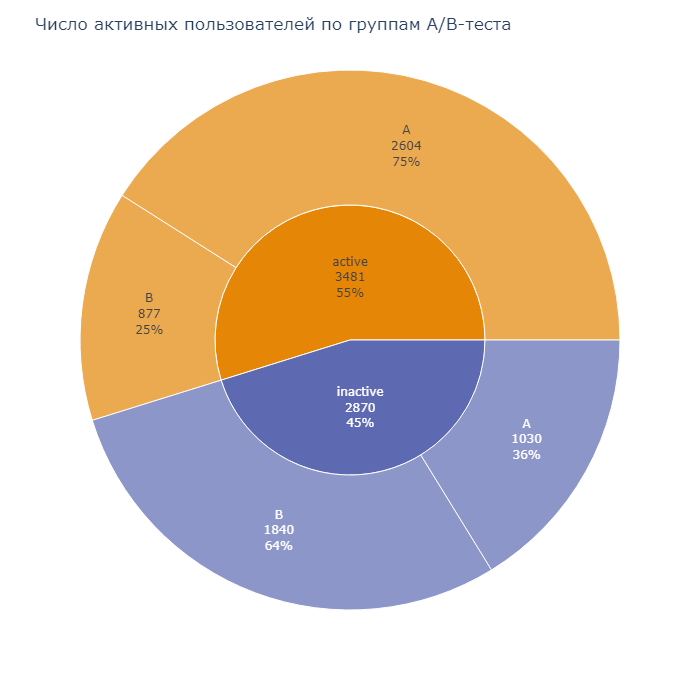

In [33]:
fig = px.sunburst(piv_1, path=['is_active','group'], values='user_id', color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(title='Число активных пользователей по группам А/В-теста',
                  width=700,
                  height=700)
fig.update_traces(textinfo='label+percent parent+value', insidetextorientation='horizontal')
fig.show("png")

Дополнительно рассмотрим динамику набора пользователей в группы среди активных и среди неактивных пользователей.

In [34]:
users_groups

,user_id,first_date,region,device,group,ab_test,is_active
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,active
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,inactive
7,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,active
10,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,active
12,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test,active
...,...,...,...,...,...,...,...
18255,A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test,active
18259,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test,active
18261,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test,active
18262,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,active


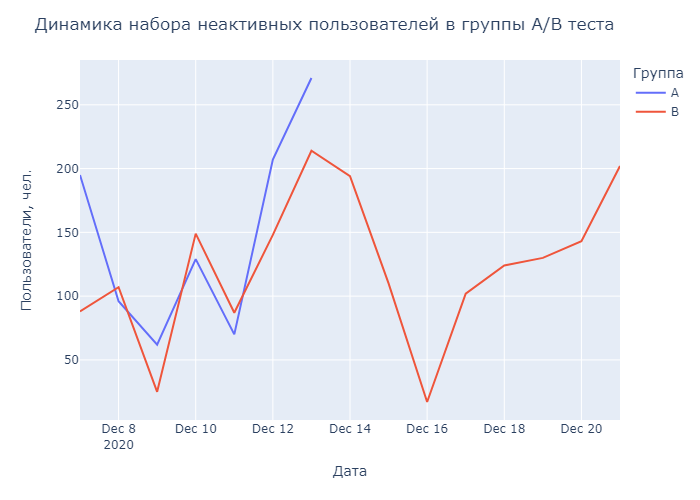

In [35]:
tmp=users_groups.query('is_active=="inactive"').pivot_table(index=['first_date','group','is_active'],values='user_id',aggfunc='nunique').reset_index()
fig = px.line(tmp, x="first_date", y="user_id",color='group')
fig.update_layout(title='Динамика набора неактивных пользователей в группы А/В теста',
                   xaxis_title='Дата',
                   yaxis_title='Пользователи, чел.',
                 legend_title_text='Группа')
fig.show("png")

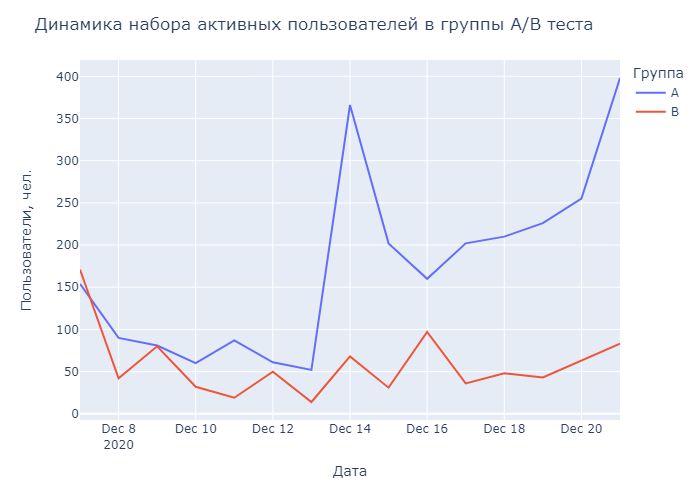

In [36]:
tmp=users_groups.query('is_active=="active"').pivot_table(index=['first_date','group','is_active'],values='user_id',aggfunc='nunique').reset_index()
fig = px.line(tmp, x="first_date", y="user_id",color='group')
fig.update_layout(title='Динамика набора активных пользователей в группы А/В теста',
                   xaxis_title='Дата',
                   yaxis_title='Пользователи, чел.',
                 legend_title_text='Группа')
fig.show("png")

Графики динамики набора пользователей в группы показывают, что **активные** пользователи набирались в группы **на протяжении всего заданного периода**, причем **в группу А 14 декабря было** набрано значительно **больше** активных пользователей, чем **в группу В**, и число их имеет тенденцию к увеличению к концу заданного периода.

В то же время, график **динамики набора неактивных пользователей** показывает, что они набирались в обе группы примерно одними темпами, но 13 декабря их набор в **группу А прекратился**, а в **группу В** они продолжали набираться все оставшееся время.

Скорее всего, именно этой аномалией объясняется такое значительное расхождение между активными пользователями в группах теста.

Более того, подобная аномалия может говорить о **серьезной ошибке**, допущенной при **формировании тестовой выборки**, что дополнительно ставит под сомнение эффективность проведения теста с такими данными в таком виде.

Судя по диаграмме, среди **активных** пользователей всего **25% из тестовой** выборки и **75% из контрольной** выборки. Впоследствии при изучении результатов АВ-теста это может привести к множеству сдвигов в определении итогового результата. Главный принцип АВ-теста - деление выборки на равные доли, и в конечном случае результаты должны получиться приблизительно похожими на реальную картину. В нашем же случае выборка значительно перекошена в сторону контрольной группы, которой изменения не предлагались, и **результат может иметь аналогичную ошибку**.

Учитывая, что базовый показатель конверсии составляет 50%, и нам необходимо протестировать группу В на изменение конверсии на 5%, калькуляторы для А/В-тестов (https://www.evanmiller.org/ab-testing/sample-size.html и https://www.optimizely.com/sample-size-calculator/?conversion=20&effect=5&significance=95#/?conversion=50&effect=5&significance=95) показывают требование к минимальному размеру выборки **5100 или 6277 человек на 1 группу теста**.

В нашем же случае для группы А это 2604 человека и для группы В это 877 человек. При таких показателях активности пользователей, результаты теста могут быть некорректными, что приведет к приняюти неверных бизнес-решений. Поэтому настоящее исследование следует рассматривать только как **проверку уже имеющихся данных**.

Более того, в исследовании нет смысла учитывать пользователей без активности вообще, поскольку это увеличит неопределенность в итоговых результатов, поскольку в отдельных случайных выборках при проверке могут оказаться и нулевые показатели, и ненулевые, что приведет к занижению или завышению средних величин по каждой из групп, а это дополнительно увеличит вероятность неверной оценки результатов.

**Лайфтайм событий**

Согласно ТЗ исследования, за 14 дней с момента регистрации в системе пользователи должны показать улучшение метрики не менее, чем на 5 процентных пунктов по целевым событиям - product_page, product_cart, purchase. Для этого необходимо будет дополнить таблицу событий датой регистрации пользователя, подсчитать срок в днях с момента регистрации до момента совершения события.

Но перед этим необходимо понять, какие события кроме целевых представлены.

In [37]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Итого имеются 4 типа событий:
- login - вход на ресурс (первоначальное действие)
- product_page - просмотр карточки товара
- purchase - покупка
- product_cart - продуктовая корзина

Каждое из этих событий важно для исследования, однако есть вероятность, что просмотр корзины может пропускаться ввиду "покупки в 1 клик", это будет рассмотрено позже.

Дополним датасет столбцом лайфтайма с момента регистрации для каждого события. Будем рассчитывать её как разницу между днем регистрации и днем события (в количестве дней).

In [38]:
events = events.merge(users_groups[['user_id','first_date']])
events['days_to_event'] = (events['event_dt'] - events['first_date']).dt.days
events

,user_id,event_dt,event_name,details,first_date,days_to_event
0,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,0
1,831887FE7F2D6CBA,2020-12-09,purchase,99.99,2020-12-07,2
2,831887FE7F2D6CBA,2020-12-07,product_cart,NaN,2020-12-07,0
3,831887FE7F2D6CBA,2020-12-08,product_cart,NaN,2020-12-07,1
4,831887FE7F2D6CBA,2020-12-09,product_cart,NaN,2020-12-07,2
...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27,login,NaN,2020-12-21,6
23416,BEF16764A13AEC34,2020-12-21,login,NaN,2020-12-21,0
23417,BEF16764A13AEC34,2020-12-22,login,NaN,2020-12-21,1
23418,BEF16764A13AEC34,2020-12-24,login,NaN,2020-12-21,3


In [39]:
events['days_to_event'].max()

23

Максимальный срок между действиями пользователей - 23 дня, но поскольку проверяется активность в течение первых 14 дней с даты регистрации, уберем все лишние значения, в которых лайфтайм более 14.

In [40]:
events=events.query('days_to_event <= 14')
events

,user_id,event_dt,event_name,details,first_date,days_to_event
0,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,0
1,831887FE7F2D6CBA,2020-12-09,purchase,99.99,2020-12-07,2
2,831887FE7F2D6CBA,2020-12-07,product_cart,NaN,2020-12-07,0
3,831887FE7F2D6CBA,2020-12-08,product_cart,NaN,2020-12-07,1
4,831887FE7F2D6CBA,2020-12-09,product_cart,NaN,2020-12-07,2
...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27,login,NaN,2020-12-21,6
23416,BEF16764A13AEC34,2020-12-21,login,NaN,2020-12-21,0
23417,BEF16764A13AEC34,2020-12-22,login,NaN,2020-12-21,1
23418,BEF16764A13AEC34,2020-12-24,login,NaN,2020-12-21,3


In [41]:
events.pivot_table(index='event_name',values='days_to_event',aggfunc=['median','mean']).reset_index()

,event_name,median,mean
,,days_to_event,days_to_event
0,login,2,2.947833
1,product_cart,2,2.926246
2,product_page,2,2.939674
3,purchase,2,2.887928


В среднем между регистрацией и каждым действием у имеющихся пользователей проходит чуть менее чем 3 дня. Это, скорее всего, достаточно хороший показатель, если сервис предлагает товары или услуги достаточно высокой стоимости. Таким образом, покупательское поведение вполне нормально.

Для большей наглядности построим гистограмму лайфтаймов событий.

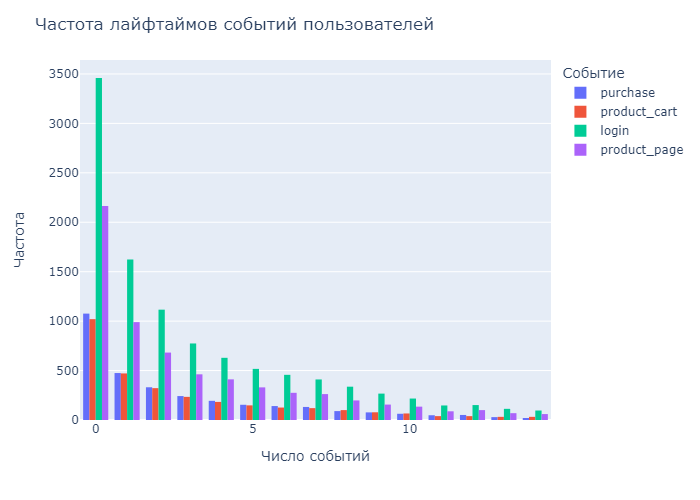

In [42]:
fig = px.histogram(events, x="days_to_event",color='event_name')
fig.update_layout(title='Частота лайфтаймов событий пользователей',
                   xaxis_title='Число событий',
                   yaxis_title='Частота',
                 legend_title_text='Событие',
                 barmode='group')
fig.show("png")

Действительно, большинство событий происходят в первые пару дней со дня регистрации пользователя. При этом, среди самых частых событий, в день регистрации происходит большинство действий, как входов в сервис, так и просмотров карточки товара, корзины, и покупки. Одновременно, просмотров корзины немногим меньше, чем покупок. Далее этот фактор будет рассмотрен отдельно.

### Выводы предобработки данных

По итогам предобработки данных и первого их обзора были обработаны все массивы данных и приведены к должному виду форматы записей в таблицах.

Предварительное изучение данных позволило сделать выводы о том, что:
- Существуют **маркетинговые активности**, которые **пересекаются** с временем активности пользователей сервиса.
- Выборка пользователей **по дате регистрации была** проведена **некорректно** и в нее попала часть некорретных дат регистрации. Расхождения ликвидированы.
- Были отобраны пользователи целевого региона и рассчитано целевое количество пользователей для теста: **6371 человек**
- Были обнаружены данные конфликтующего теста, причем пользователи обоих тестов частично пересекаются между собой. Ввиду недостаточности количества пользователей целевого теста, остающихся в выборке, принято решение сохранить пересекающихся пользователей. *Для этих пользователей данные активности могут быть искажены*
- Последнее событие пользователей в выборке относится к 30 декабря 2020 года. Правая граница исследования - 04 января 2021 года. *Данные по активности пользователей могут быть неполными, в связи с чем возможны искажения в показателях активностей по типам*.
- Имеются данные по **активности** только **55%** пользователей из всей выборки АВ-теста. При этом, среди активных пользователей **75%** приходится на **контрольную группу (А)** и только **25%** на **группу В**. *Результаты АВ-теста могут быть значительно искажены при таком значительном неравенстве выборок*.
- Максимальный лайфтайм событий с момента регистрации для пользователей составляет **23 дня**, что значительно выше установленных техническим заданием **14 дней**. Излишние данные удалены, *возможны незначительные искажения результатов*.

С учетом всего вышеописанного, можно уже на этапе подготовки данных тестов к проверке заявить о том, что конечный результат будет серьезно **искажен**. Для того, чтобы корректно составить выборку данных для теста и соблюсти основные принципы АВ-тестирования, необходимо значительно изменить методику отбора пользователей в группы. В частности, необходимо присваивать группу пользователю не только на этапе регистрации, но и рассматривать дополнительный фактор совершения как минимум **1 (одного) действия** после регистрации. В этом случае будет более корректно формироваться клиентская воронка, поскольку **факт регистрации не является показателем активности** пользователя.

## Исследовательский анализ данных

Частично уже был проведен анализ данных при их загрузке и обработке.

В рамках настоящего исследовательского анализа ответим на следующие вопросы:

- Распределение количества событий на пользователя в разрезе групп теста: построим графикраспределения этой величины в разрезе групп и сравним её средние значения между собой у групп теста;
- Динамика количества событий в группах теста по дням: изучим распределение числа событий по дням и сравним динамику групп теста между собой.
- Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями. Настройте автоматическую проверку, выдающую список событий, пересекающихся с тестом. Также оценим воздействие маркетинговых событий на динамику количества событий пользователей.
- Продуктовая воронка: построим простые продуктовые воронки для двух групп теста с учетом логической последовательности совершения событий; изучим изменение конверсии в продуктовой воронке тестовой группы, по сравнению с контрольной.

Для анализа будем использовать объединенный датасет пользователей по группам и пользовательских событий. В датасете будут встречаться только данные активных пользователей, число которых уже оценивалось выше и описывалась достаточность выборки для исследования.

In [43]:
df=events.merge(users_groups[['user_id','device','group','region']])
df

,user_id,event_dt,event_name,details,first_date,days_to_event,device,group,region
0,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,0,Android,A,EU
1,831887FE7F2D6CBA,2020-12-09,purchase,99.99,2020-12-07,2,Android,A,EU
2,831887FE7F2D6CBA,2020-12-07,product_cart,NaN,2020-12-07,0,Android,A,EU
3,831887FE7F2D6CBA,2020-12-08,product_cart,NaN,2020-12-07,1,Android,A,EU
4,831887FE7F2D6CBA,2020-12-09,product_cart,NaN,2020-12-07,2,Android,A,EU
...,...,...,...,...,...,...,...,...,...
22823,1484BBF124DB1B18,2020-12-27,login,NaN,2020-12-21,6,PC,A,EU
22824,BEF16764A13AEC34,2020-12-21,login,NaN,2020-12-21,0,PC,B,EU
22825,BEF16764A13AEC34,2020-12-22,login,NaN,2020-12-21,1,PC,B,EU
22826,BEF16764A13AEC34,2020-12-24,login,NaN,2020-12-21,3,PC,B,EU


### Общие параметры данных

Для начала взглянем на основные распределения данных в объединенном датасете.

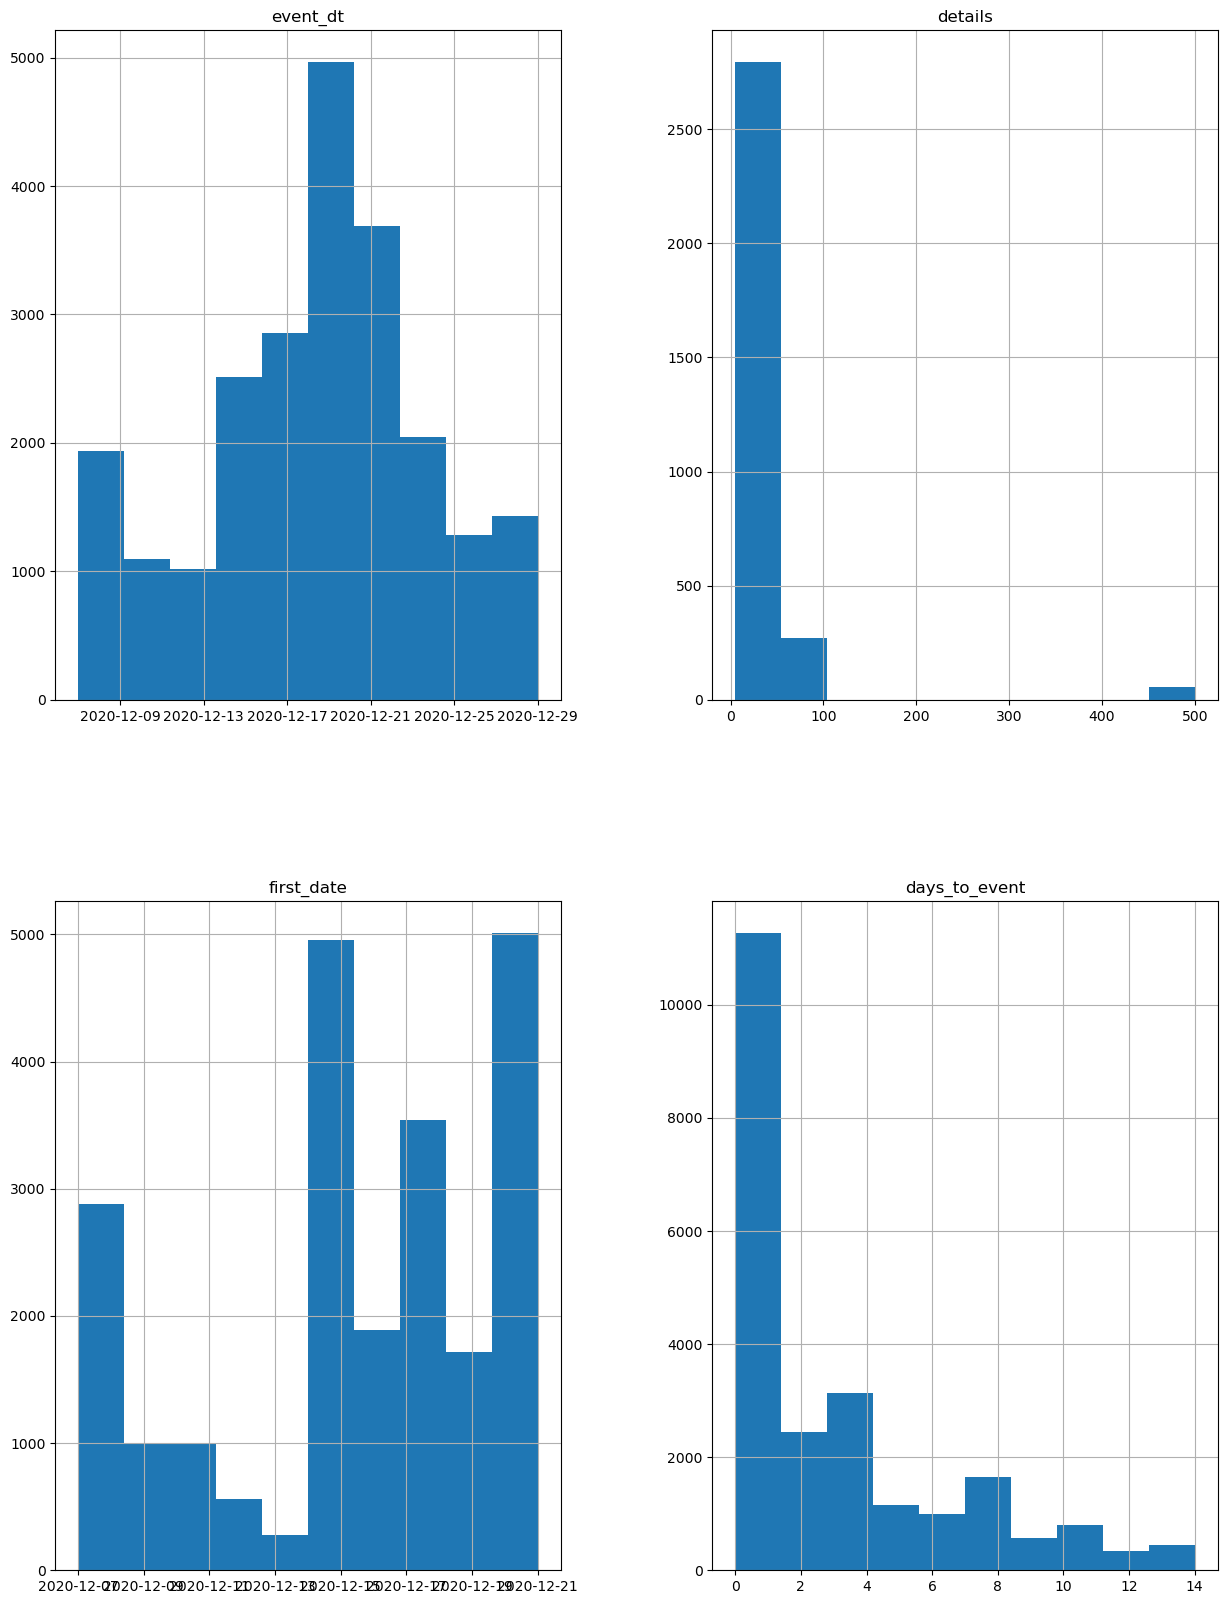

In [44]:
df.hist(figsize=(15, 20))
plt.show()

In [45]:
df.describe()

,details,days_to_event
count,3123.000000,22828.00000
mean,23.046356,2.93451
std,70.266952,3.47750
min,4.990000,0.00000
25%,4.990000,0.00000
50%,4.990000,2.00000
75%,9.990000,5.00000
max,499.990000,14.00000


Из полученных гистограмм и описательных статистик видно, что чаще всего пользователи регистрировались в сервисе в середине декабря 2020 года. При этом, больше всего событий пользователей приходится на вторую половину месяца. Одновременно с этим, события пользователей происходили в первые три дня с даты регистрации. Покупки совершались на суммы до 100 долларов и также несколько покупок на сумму до 500 долларов.

Из описательных статистик видно, что было сделано всего 3123 покупки от 4,99 до 499,99 долларов, со средним значением 23,04 доллара.

Интервал между датой регистрации и событием в среднем составил 2,93 дня, минимальный интервал - 0 дней (то есть, событие происходило в день регистрации), максимальный - 14 дней.

Построим диаграмму распределения пользователей по группам в разрезе пользовательских устройств.

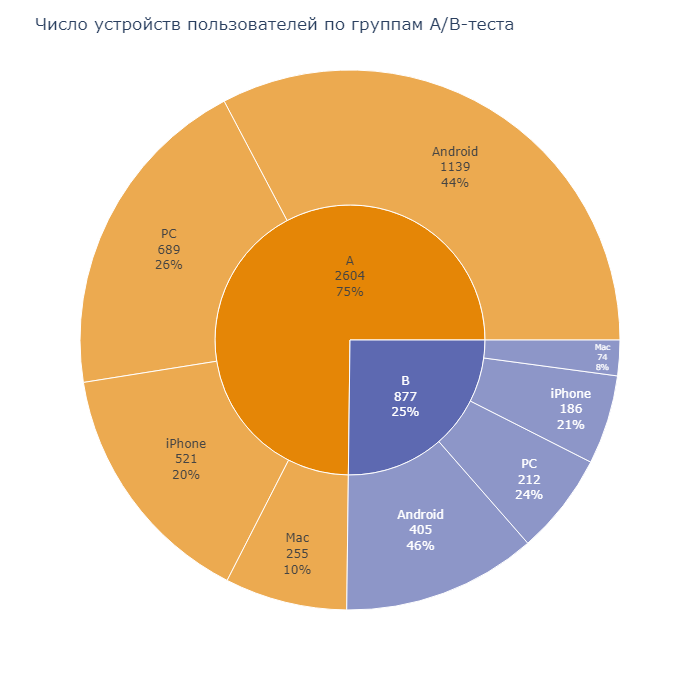

In [46]:
tmp=df.pivot_table(index=['group','device'],values='user_id',aggfunc='nunique').reset_index()
fig = px.sunburst(tmp, path=['group','device'], values='user_id', color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(title='Число устройств пользователей по группам А/В-теста',
                  width=700,
                  height=700)
fig.update_traces(textinfo='label+percent parent+value', insidetextorientation='horizontal')
fig.show("png")

Несмотря на то, что, как подчеркивалось ранее, пользователи групп А и В распределены неравномерно и группа В значительно меньше контрольной группы А, распределение устройств пользователей приблизительно равное: чуть более 40% людей пользуется Android, около четверти - РС, по 20-21% приходится на iPhone и 8-10% приходится на Mac.

Дополнительно можно рассмотреть, какое количество денег принесла каждая группа теста по дням наблюдения.

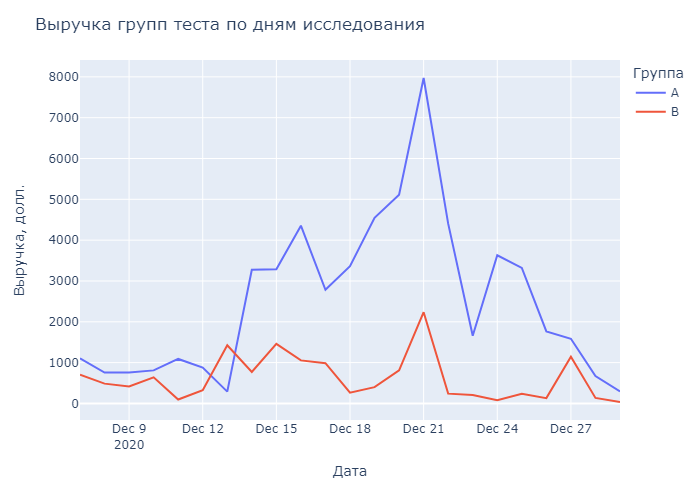

In [47]:
tmp=df.pivot_table(index=['event_dt','group'],values='details',aggfunc='sum').reset_index()
fig = px.line(tmp, x="event_dt", y=["details"],color='group')
fig.update_layout(title='Выручка групп теста по дням исследования',
                   xaxis_title='Дата',
                   yaxis_title='Выручка, долл.',
                 legend_title_text='Группа')
fig.show("png")

По двум графикам видно, что выручка контрольной группы стабильно выше, чем выручка группы В. Здесь серьезно сказывается эффект масштаба от того, что имеется значительный перекос в сторону контрольной группы, поэтому с 14 декабря появляется значительное расхождение между выручками по группам, и уменьшается только к последним датам исследования.

Одновременно, наблюдается пик в районе 21 декабря. Учитывая, что в ЕС это канун Рождества, на которое, как правило, люди приобретают друг другу подарки, такое поведение графиков вполне логично. Вместе с этим, начавшаяся 25 декабря маркетинговая кампания дала второй пик для группы В, практически не повлияв на группу А.

Дополнительно, если вернуться к графикам **динамики набора** пользователей в группу А, будет заметно, что первый значительный **пик пришелся на 14 декабря**, и **16 декабря** выручка незначительно **выросла**. Далее наблюдался восходящий тренд в наборе активных пользователей - и он выразился во втором значительном пике 21 декабря. Таким образом, **увеличение числа активных пользователей увеличивает выручку по группе.**

### Количество событий на пользователя в разрезе групп теста

Для каждой из групп теста можно рассмотреть количество событий на одного пользователя. Может оказаться так, что пользователи тестовой группы не только малочисленны, но и имеют количество событий меньше, чем пользователи контрольной группы.

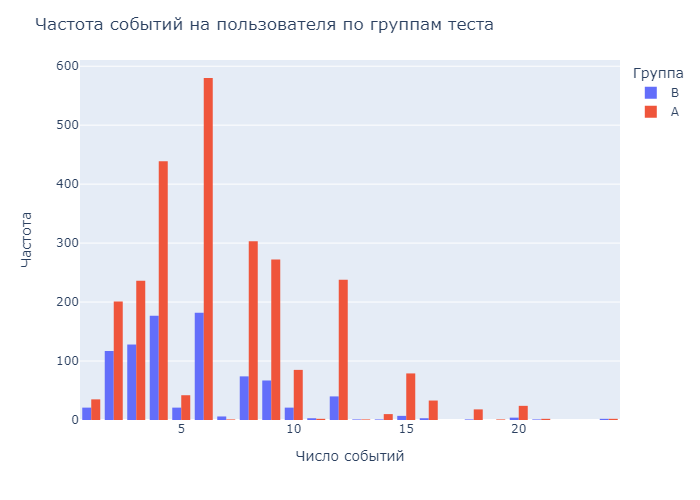

In [48]:
tmp=df.pivot_table(index=['user_id','group'],values='event_name',aggfunc='count').reset_index()
fig = px.histogram(tmp, x="event_name",color='group')
fig.update_layout(title='Частота событий на пользователя по группам теста',
                   xaxis_title='Число событий',
                   yaxis_title='Частота',
                 legend_title_text='Группа',
                 barmode='group')
fig.show("png")

Гистограмма событий на пользователя показывает, что **в группе А** происходило намного **больше событий**, чем **в группе В**. При этом, **в тестовой** группе, несмотря на **в три раза меньшее** число участников, **до 3 событий** происходило **всего в два раза меньше**. 

Возможно, это связано с тем, что новая система рекомендаций работала и вызывала в пользователях желание создавать новые события. 4 и 6 событий в контрольной группе происходило значительно больше, чем в тестовой. Тем не менее, **с учетом разницы в числе активных** пользователей в группах теста, **нельзя однозначно судить** о том, вызвала ли новая система рекомендаций ожидаемый эффект.

### Динамика количества событий в группах теста по дням

Также рассмотрим количество событий в группах теста по дням. Возможно, что ввиду малого количества пользователей в группе В, события в группе также будут значительно реже.

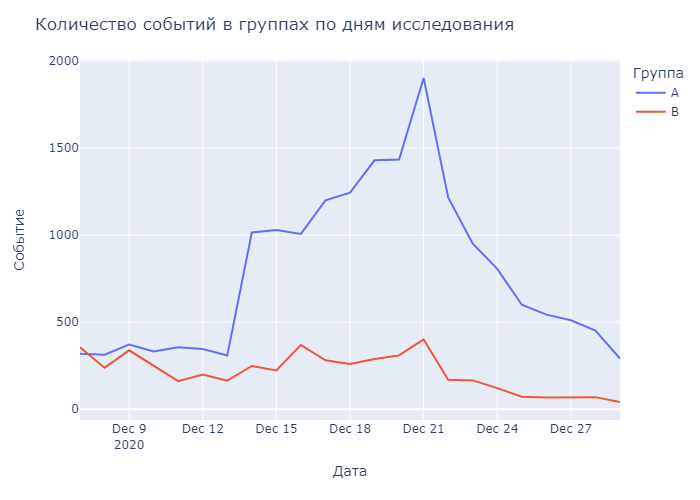

In [49]:
tmp=df.pivot_table(index=['event_dt','group'],values='event_name',aggfunc='count').reset_index()
fig = px.line(tmp, x="event_dt", y=["event_name"],color='group')
fig.update_layout(title='Количество событий в группах по дням исследования',
                   xaxis_title='Дата',
                   yaxis_title='Событие',
                 legend_title_text='Группа')
fig.show("png")

Действительно, ввиду небольшого количества участников тестовой группы, **количество событий на группу В** в целом было **ниже**, чем в контрольной группе. При этом стоит отметить, что в **контрольной** группе наблюдался **рост числа событий с 13 декабря до достижения пика 21 декабря** с дальнейшим резким спадом. В **тестовой** же группе резкого роста событий в аналогичный период **не наблюдалось**. 

Субъективно можно предположить, что новая рекомендательная система не повлияла значительно на число событий. Более того, она могла даже оказать негативное влияние на **показатели тестовой группы**, поскольку **отсутствует предрождественский скачок** активности.

Значительно б*о*льшее влияние на количество событий пользователей оказала активность их набора в тестовые группы. На графике явно видно первое резкое увеличение активности пользователей в числе их событий, соответствующее пику набора в группу А, далее активность пользователей стабильно возрастает синхронно с ростом числа набираемых активных пользователей в группу.

Таким образом, показатели групп напрямую зависят от динамики набора именно **активных** пользователей в их состав.

### Пересечение с маркетинговыми кампаниями

Как было установлено ранее, в целевой промежуток исследования попадает проведение одной маркетинговой кампании. Необходимо показать, какая маркетинговая кампания попадает в даты проведения теста.

In [50]:
# Отбор кампании по региону выставляем руками по ТЗ
reg_camp = market_events[(market_events['regions'].str.contains("EU"))&(market_events['finish_dt'] > df['event_dt'].min())]
reg_camp

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Кампания, попавшая в тест, - рождественско-новогодняя промо-кампания для ЕС и США. При этом, ранее в активности пользователей по датам, уже было обнаружено, что еще до начала этой кампании пользовательская активность начала снижаться.

Можно показать это наглядно на графике.

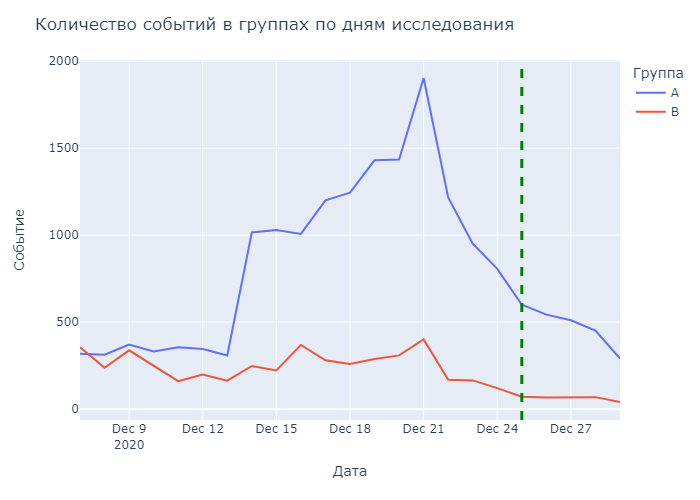

In [51]:
tmp=df.pivot_table(index=['event_dt','group'],values='event_name',aggfunc='count').reset_index()
fig = px.line(tmp, x="event_dt", y=["event_name"],color='group')
fig.update_layout(title='Количество событий в группах по дням исследования',
                   xaxis_title='Дата',
                   yaxis_title='Событие',
                 legend_title_text='Группа')
fig.add_vline(x='2020-12-25', line_width=3, line_dash="dash", line_color="green")
fig.show("png")

Таким образом, маркетинговая кампания не оказала влияния на пользовательскую активность, поэтому нельзя говорить о том, что ее проведение может дополнительно к уже упомянутым факторам исказить результаты теста.

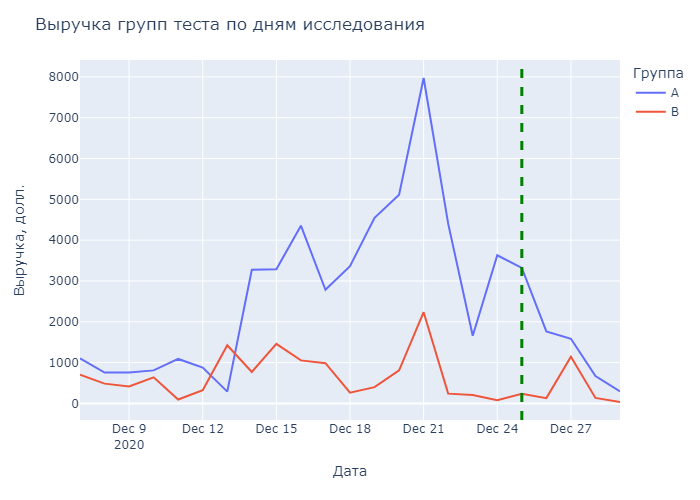

In [52]:
tmp=df.pivot_table(index=['event_dt','group'],values='details',aggfunc='sum').reset_index()
fig = px.line(tmp, x="event_dt", y=["details"],color='group')
fig.update_layout(title='Выручка групп теста по дням исследования',
                   xaxis_title='Дата',
                   yaxis_title='Выручка, долл.',
                 legend_title_text='Группа')
fig.add_vline(x='2020-12-25', line_width=3, line_dash="dash", line_color="green")
fig.show("png")

Маркетинговая кампания также не оказала значительного влияния на выручку по группам. с 25 декабря и до конца зарегистрированной активности для контрольной группы она стабильно снижалась, а у тестовой группы был зарегистрирован незначительный всплеск выручки 27 декабря, после чего снижение продолжилось.

### Пользовательская воронка

Для рассмотрения пользовательской активности также можно построить пользовательскую воронку по известным этапам движения клиента.

При этом необходимо понимать, что в отдельных случаях сервис может иметь возможность покупки в 1 клик, и тогда пользователь будет пропускать этап с открытием корзины и из этапа просмотра карточки товара будет переходить сразу к этапу покупки.

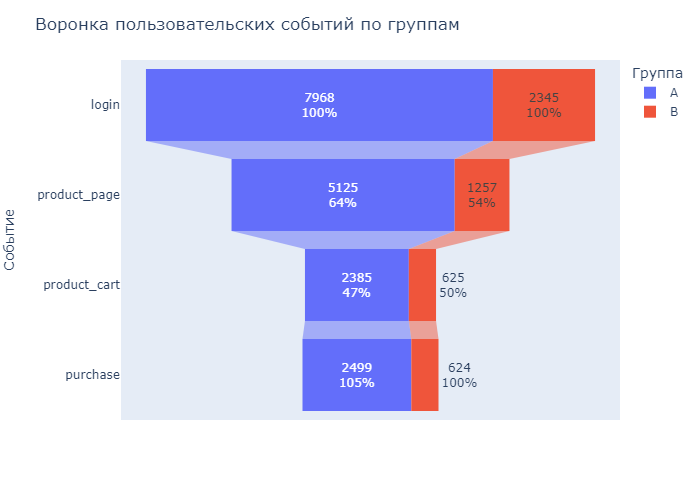

In [53]:
tmp=df.pivot_table(index=['event_name','group'],values='user_id',aggfunc='count').reset_index()
tmp=tmp.reindex(index=[0,1,4,5,2,3,6,7])
fig = px.funnel(tmp, x='user_id', y='event_name', color='group')
fig.update_layout(title='Воронка пользовательских событий по группам',
                   yaxis_title='Событие',
                 legend_title_text='Группа')
fig.update_traces(textinfo='value+percent previous', selector=dict(type='funnel'))
fig.show("png")

Поскольку **стадия корзины не является обязательной** в прохождении клиентом, к ней приходит немногим меньше пользователей, чем на стадию покупки. Поэтому, можно перестроить воронку без нее.

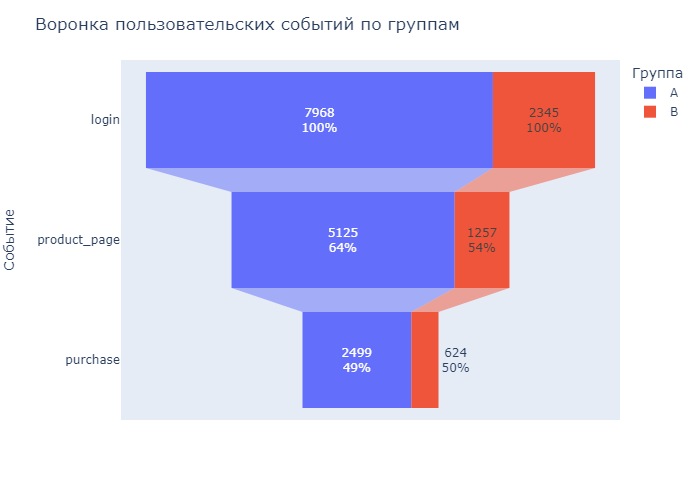

In [54]:
fig = px.funnel(tmp.query('event_name != "product_cart"'), x='user_id', y='event_name', color='group')
fig.update_layout(title='Воронка пользовательских событий по группам',
                   yaxis_title='Событие',
                 legend_title_text='Группа')
fig.update_traces(textinfo='value+percent previous', selector=dict(type='funnel'))
fig.show("png")

По сокращенной воронке мы видим, что **из всех залогинившихся** пользователей **карточку товара** просматривают **64% из группы А** и **54% из группы В**. На стадию **покупки** проходят **49% пользователей из группы А** и **50% пользователей из группы В**.

Учитывая, что из вводных параметров теста следует, что **базовый уровень конверсии 50%**, и тест должен был показать **прирост в целевые 5% для тестовой группы**, воронка показывает **значительное расхождение**. 

Выходит, что **контрольная группа** показала конверсию на **первом** переходе **на 14% больше базовой**, а **тестовая группа - на 4%**. В обоих случаях это неисполнение целевых показателей: для **контрольной** группы **перевыполнение**, для **тестовой - недовыполнение**.

**Второй** переход показал еще более искаженные результаты: для **контрольной** группы перешло на этап покупки **49% пользователей (на 1% меньше целевой конверсии)**, для **тестовой** на этап покупки перешло **50% пользователей (равный базовому показатель, недовыполнение целевого для теста на 5%)**.

Таким образом, **пользовательская воронка** событий **дополняет** ранее обозначавшиеся серьезные **искажения в данных**.

### Выводы исследовательского анализа данных

Исследовательский анализ данных показал, что **между тестовой и контрольной группой имеются серьезные расхождения**. Активные **пользователи между группами распределены неравномерно**: **75%** находятся в **контрольной** группе и только **25%** - в **тестовой** группе. При этом по **типам устройств** в обеих группах наблюдаются **примерно равные пропорции**.

**Выручка** групп теста по дням также показывает **значительное расхождение**, причем **группа А** показывает более **резкие увеличения выручки в предрождественские дни**. После **22 декабря** дневная **выручка снижается**, показывая **небольшие всплески** в тестовой группе в районе **27 декабря**.

В части **пользовательской активности** тестовая **группа В** также значительно **отстает** от контрольной **группы А**, показывая в 2 и более раз низкую активность.

**Число событий в группе А** по дням значительно **выше, чем в группе В**, поскольку активных **пользователей** в контрольной группе примерно **в 3 (три) раза больше, чем в тестовой**. Одновременно с этим наблюдается **резкое увеличение активности в периоде с 14 по 21 декабря**, когда, скорее всего, пользователи из ЕС заказывали подарки на католическое Рождество. **С 22 декабря** и до последнего дня с зарегистрированной активностью **(30 декабря)** пользователи совершают все меньше и **меньше событий в обеих группах.**

На время проведения теста приходится проведение **1 (одной) маркетинговой промо-кампании** в ЕС с **25 декабря 2020 года по 4 января 2021 года**. Несмотря на эту кампанию, **поведение** пользователей **не изменялось**, равно как не изменялась и их активность, имея **тенденцию к снижению** в периоде по 30 декабря. Выручка контрольной группы не была подвержения влиянию кампании, стабильно снижаясь, а для тестовой группы наблюдался один небольшой всплеск 27 декабря.

**Пользовательская воронка** дополнительно наглядно показала значительную смещенность выборок групп пользователей, где 3/4 пользователей относятся к контрольной группе. При этом дополнительно было установлено, что не все пользователи доходят до этапа покупки, проходя через корзину покупок, в связи с чем **посещение корзины** было определено как **необязательный этап пользовательского пути**. Без этого этапа конверсия по воронке показала результаты, которые изначально **не предусматривались ТЗ**, а именно:
* Для **контрольной** группы конверсия на этапе **"вход в сервис - просмотр карточки твоара"** составила **64%**, при установленном базовом показателе **50%**. Для **тестовой группы** на этом же этапе конверсия показала **54%** при ожидаемом эффекте новой системы рекомендаций **55%**.
* На этапе **"просмотр карточки товара - покупка** также были показаны **нестандартные** результаты. В **группе А** конверсия в этап составила **49%** при ожидаемых стандартных **50%**. В **группе В** конверсия в этап составила ровно **50%**, что соответствует **стандартной** и **не соответствует ожидаемому эффекту**.

По итогам исследовательского анализа данных уже можно сказать о том, что дорогостоящий А/В-тест, который провела кампания, ввиду **большого количества ошибок** в формировании **выборки пользователей**, не увенчался успехом. Оказалось, что в тест были включены пользователи, половина из которых **не была активна вообще**, что сказалось на итоговых результатах.

## Оценка результатов А/В-теста

Несмотря на то, что уже установлено, что проведенный АВ-тест имеет множество ошибок при отборе пользователей в тестовые группы, необходимо подсчитать статистические критерии для того, что есть в распоряжении без исправлений. 

Цель теста была следующей:
Проверить, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
* конверсии в просмотр карточек товаров — событие product_page
* просмотры корзины — product_cart
* покупки — purchase.

Как уже было установлено при исследовательском анализе, просмотр корзины не является обязательным этапом пользовательского пути, поэтому проверим статистические показатели для конверсии login - product_page и для конверсии product_page - purchase.

На пользовательской воронке это уже показывалось наглядно, поэтому проведем дополнительные статистические тесты для подкрепления доводов, сделанных ранее.

### Проверка гипотезы о равенстве долей тестовых выборок

В первую очередь проверим гипотезу о равенстве долей тестовых выборок. Если опустить ранее сделанные выводы исследовательского анализа данных, выведем две гипотезы для проверки и проверим, статистически ли значимы различия в конверсии между группами для этапа login - product_page и потом для этапа product_page - purchase.

Н0: Конверсии этапа login - product_page для обеих групп равны

Н1: Конверсии этапа login - product_page для обеих групп неравны

In [55]:
# Построим сводную таблицу для оценки.
funnel=df.pivot_table(index=['event_name','group'],values='user_id',aggfunc='count').reset_index().query('event_name != "product_cart"')
funnel

,event_name,group,user_id
0,login,A,7968
1,login,B,2345
4,product_page,A,5125
5,product_page,B,1257
6,purchase,A,2499
7,purchase,B,624


In [56]:
alpha = 0.05/2  # Вводим поправку Бонферрони, поскольку рассматривается две гипотезы

product_page = np.array([5125, 1257])
login = np.array([7968, 2345])

p1 = product_page[0]/login[0]
p2 = product_page[1]/login[1]

p_combined = (product_page[0] + product_page[1])/(login[0] + login[1])

difference = p1 - p2

z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/login[0] + 1/login[1]))
distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2 

print('p-значение: ', p_value)

if p_value < alpha: 
    print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница


Впрочем, это было показано уже пользовательской воронкой, и Z-тест дополнительно показал, что конверсии в группах на первом этапе серьезно отличаются.

Проверим разницу в конверсиях на этапе product_page - purchase

Н0: Конверсии этапа product_page - purchase для обеих групп равны

Н1: Конверсии этапа product_page - purchase для обеих групп неравны

In [57]:
alpha = 0.05/2  # Вводим поправку Бонферрони, поскольку рассматривается две гипотезы

product_page = np.array([5125, 1257])
purchase = np.array([2499, 624])

p1 = purchase[0]/product_page[0]
p2 = purchase[1]/product_page[1]

p_combined = (purchase[0] + purchase[1])/(product_page[0] + product_page[1])

difference = p1 - p2

z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/product_page[0] + 1/product_page[1]))
distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2 

print('p-значение: ', p_value)

if p_value < alpha: 
    print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными'
    )

p-значение:  0.5755084094397782
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


На втором этапе конверсии практически одинаковы, поэтому нельзя говорить о том, что в тестовой группе был достигнут результат, который закладывался при введении новой системы рекомендаций.

**Выводы по Z-тесту**

Как было установлено, конверсии на первом этапе в контрольной и тестовой группе разные. Это было отображено на пользовательской воронке и подтверждено статистическим тестом.

На втором этапе конверсии в контрольной и тестовой группах оказались статистически равными, на пользовательской воронке это также было отражено, и была установлена разница между ними в 1%.

Поскольку тестовая группа испытывала новую систему рекомендаций, и ожидалось, что конверсия в этой группе будет на 5% больше, чем в контрольной, уже на данном этапе можно говорить о том, что цели введения новой системы рекомендаций достигнуты не были, и эксперимент можно признать неудачным.

Однако, не стоит забывать о том, что данные для А/В-теста были собраны некорректно и было получено значительное смещение в сторону контрольной группы, в связи с чем данные самого теста, скорее всего, искажены.

### Выводы о проведенном А/В-тесте

Подытоживая ранее проведенный исследовательский анализ данных, изучение активности пользователей, пользовательскую воронку и проведенный статистический тест равенства конверсий по группам, можно прийти к следующим выводам.

В целом, **тест был проведен некорректно** на этапе **сбора данных** и **распределения** пользователей по группам.

Активных пользователей в контрольной группе А оказалось в три раза больше, чем в тестовой группе. Сказался эффект от масштаба и конечные показатели контрольной группы оказались выше.

Показатели конверсии в обеих группах в свою очередь показали странные результаты. **На первом этапе** перехода от входа в учетную запись сервиса до просмотра карточки продукта, **конверсия группы А (64%) оказалась выше, чем группы В (54%), и выше базового показателя 50%.**

**На втором этапе** при переходе от просмотра карточки товара к покупке, **группа А** показала конверсию **49%**, а **группа В - 50%**. В обоих случаях эти результаты:
* Весьма похожи друг на друга, что подтверждается статистическим тестом;
* Не соответствуют базовому (50%) для группы А и целевому (55%) для группы В.

Тест **нельзя считать успешным**, поскольку были нарушены принципы формирования тестовых выборок.

## Выводы

Проведенный исследовательский анализ данных, а также проверка статистических гипотез показали **результаты** проведенного дорогостоящего **А/В-теста, отличные от ожидаемых** руководством компании.

Были допущены **серьезные ошибки**, повлиявшие на оценку результатов теста:
* Были некорректно отобраны пользователи в группы, что привело к тому, что из общей выборки **активных пользователей было около половины**;
* Ввиду некорректного отбора были **неравномерно сформированы группы теста**, и на контрольную группу пришлось 75% всех активных пользователей;
* **Не были собраны данные** за период **с 30 декабря 2020 года по 04 января 2021 года**, что нарушило сроки проведения теста.

Дополнительно, было установлено, что **одновременно с тестом** новой системы рекомендаций, **проходил другой тест** нового интерфейса для того же целевого региона, и часть пользователей участвовала в обоих тестах, что **могло сказаться** на их активности.

Значительный **"перекос" в количестве пользователей контрольной группы исказил** показатели активности пользователей по дням, а также графики их выручки и гистограмму распределения пользовательских событий.

Проводимая во время теста **маркетинговая кампания не оказала значительного влияния** на пользовательскую активность и поведение, поскольку проходила с 25 декабря 2020 года, когда рождественские праздники в целевом регионе ЕС уже прошли, и люди уже приобрели подарки ранее.

**Пользовательская воронка** позволила установить, что в активность пользователей включается **необязательный фактор - просмотр корзины**, что утяжеляет исследование пользовательской активности, создавая излишний "шум" в данных. Сокращенная воронка показала также значительное преобладание контрольной группы и неожиданные данные о конверсии по этапам. **На первом этапе** перехода от входа в учетную запись сервиса до просмотра карточки продукта, **конверсия группы А (64%) оказалась выше, чем группы В (54%), и выше базового показателя 50%.** На **втором этапе** при переходе от просмотра карточки товара к покупке, **группа А** показала конверсию **49%**, а **группа В - 50%**.

**Статистический тест** равенства конверсий по группам дополнил наглядные данные воронки и доказал, что конверсии на первом этапе статистически разные, а на втором этапе - практически не отличаются.

**По итогам анализа** можно заявить, что **проведенный А/В-тест неуспешен**, и по имеющимся показателям, **новая система** рекомендаций **не оправдала** возлагавшихся на нее ожиданий.

**Рекомендации**:
* Изменить подход к набору пользователей в группы теста, обеспечив отбор действительно активных пользователей (тех, кто совершил как минимум одно действие после регистрации в требуемый период);
* Разграничить пользователей, попадающих в группы параллельных тестирований для исключения влияния сторонних факторов;
* Дополнить данные об активности пользователей отсутствующим периодом с 30 декабря 2020 года по 04 января 2021 года;
* Заново провести сегментацию пользователей по группам теста с учетом упомянутых выше рекомендаций;
* Заново провести новый тест с учетом предыдущих рекомендаций.